# Chapter 1: Introduction

### Identifying the Key Connectors Among a Network

You are given a data dump (in real life, people don't typically hand you the data you need, we'll learn that in further chapters.), What does this data dump look like? It consists of a list of users, each
 represented by a 
dict
 that contains that user’s 
id
 (which is a number) and
 name
 (which, in one of the great cosmic coincidences, rhymes with the
 user’s 
id
 ):

In [1]:
users = [ 
    { "id": 0, "name": "Hero" }, 
    { "id": 1, "name": "Dunn" }, 
    { "id": 2, "name": "Sue" }, 
    { "id": 3, "name": "Chi" }, 
    { "id": 4, "name": "Thor" }, 
    { "id": 5, "name": "Clive" }, 
    { "id": 6, "name": "Hicks" }, 
    { "id": 7, "name": "Devin" }, 
    { "id": 8, "name": "Kate" }, 
    { "id": 9, "name": "Klein" } 
]

You're also given "friendship" data, represented as a list of pairs of IDs. 

In [2]:
friendship_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4), 
                    (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

#  For example, the tuple (0, 1) indicates that the data scientist with id
#  0 (Hero) and the data scientist with id 1 (Dunn) are friends.

The Network illustration will look something like this visually:
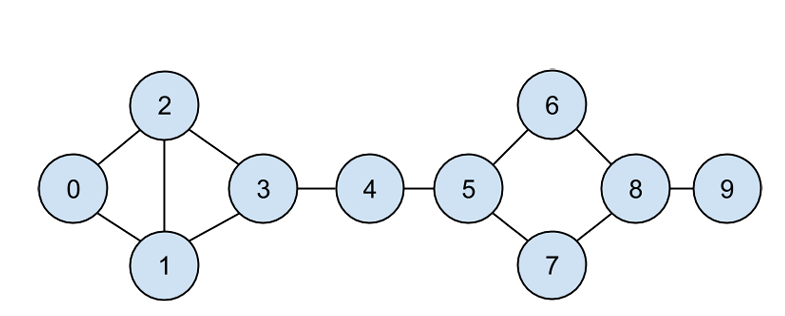

 Having friendships represented as a list of pairs is not the easiest way to
 work with them. To find all the friendships for user 1, you have to iterate
 over every pair looking for pairs containing 1. If you had a lot of pairs, this
 would take a long time.
 Instead, let’s create a 
dict
 where the keys are user 
id
 s and the values are
 lists of friend 
id
 s. (Looking things up in a 
dict
 is very fast.)

 We’ll still have to look at every pair to create the 
dict
 , but we only have to
 do that once, and we’ll get cheap lookups after that:

In [3]:
# Initialize the dict with an empty list for each user id:
friendships= {user["id"]: [] for user in users}

# And then loop over the friendship pairs to populate it:
for i, j in friendship_pairs:
    friendships[i].append(j) # Add j as a friend of user i
    friendships[j].append(i) # Add i as a friend of user j

 Now that we have the friendships in a 
dict
 , we can easily ask questions of
 our graph, like “What’s the average number of connections?”

In [4]:
def number_of_friends(user):
    """ How many friends does "user" have?"""
    user_id=user["id"]
    friend_ids=friendships[user_id]
    return len(friend_ids)

total_connections = sum(number_of_friends(user) 
                        for user in users)
assert total_connections == 24, "values are not the same"

#  And then we just divide by the number of users
num_users=len(users)
avg_connections=total_connections/num_users
assert avg_connections == 2.4, "values are not the same"

It’s also easy to find the most connected people—they’re the people who
 have the largest numbers of friends.
 Since there aren’t very many users, we can simply sort them from “most
 friends” to “least friends”:

In [5]:
num_friends_by_id=[(user["id"],
                    number_of_friends(user))
                   for user in users]

num_friends_by_id.sort(                                # Sort the list 
       key=lambda id_and_friends: id_and_friends[1],   # by num_friends 
       reverse=True)                                   # largest to smallest

# now each pair will look like this
# [(1, 3), (2, 3), (3, 3), (5, 3), (8, 3), 
#  (0, 2), (4, 2), (6, 2), (7, 2), (9, 1)]

One way to think of what we've done is as a way of identifying people who are somehow central to the network. In fact, what we've just computed is the **network metric degree centrality.**

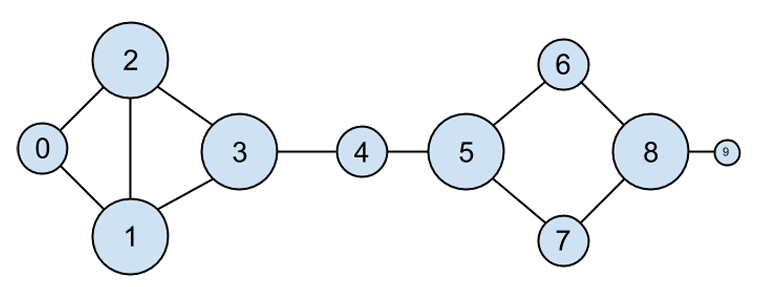

 This has the virtue of being pretty easy to calculate, but it doesn’t always
 give the results you’d want or expect As it is clear by looking at the image that
 number 4 should be more central who has only 2 connections as compared to 1 who have 3 connections.central.

### People You May Know
Lets say you want to design a people you may know suggester, your first instinct
is to suggest that users might know the friends of their friends. So you write some code to iterate over their friends and collect the friends' friends: 

In [6]:
def foaf_ids_bad(user): 
    """foaf is short for "friend of a friend" """ 
    return [foaf_id 
        for friend_id 
        in friendships[user["id"]] 
        for foaf_id 
        in friendships[friend_id]]

print(foaf_ids_bad(users[0]))
print(friendships[0])
print(friendships[1])
print(friendships[2])

[0, 2, 3, 0, 1, 3]
[1, 2]
[0, 2, 3]
[0, 1, 3]


It includes user 0 twice, since Hero is indeed friends with both of his
 friends. It includes users 1 and 2, although they are both friends with Hero
 already. And it includes user 3 twice, as Chi is reachable through two
 different friends.
  Knowing that people are friends of friends in multiple ways seems like
 interesting information, so maybe instead we should produce a count of
 mutual friends. And we should probably exclude people already known to
 the user.

In [7]:
from collections import Counter

def friends_of_friends(user): 
    user_id = user["id"] 
    return Counter( 
        foaf_id 
        for friend_id in friendships[user_id]     # For each of my friends, 
        for foaf_id in friendships[friend_id]     # find their friends 
        if foaf_id != user_id                     # who aren't me 
        and foaf_id not in friendships[user_id]   # and aren't my friends. 
    ) 
 
 
print(friends_of_friends(users[3]))               # Counter({0: 2, 5: 1})

Counter({0: 2, 5: 1})


This correctly tells Chi (
 id
 3) that she has two mutual friends with Hero (
 id 0) but only one mutual friend with Clive (
 id
 5)

### Similar Interests
As a data scientist, you know that you also might enjoy meeting users with
 similar interests. (This is a good example of the “substantive expertise”
 aspect of data science.) After asking around, you manage to get your hands
 on this data, as a list of pairs 
(user_id, interest)
 :


In [8]:
interests = [ 
    (0, "Hadoop"), (0, "Big Data"), (0, "HBase"), (0, "Java"), 
    (0, "Spark"), (0, "Storm"), (0, "Cassandra"), 
    (1, "NoSQL"), (1, "MongoDB"), (1, "Cassandra"), (1, "HBase"), 
    (1, "Postgres"), (2, "Python"), (2, "scikit-learn"), (2, "scipy"), 
    (2, "numpy"), (2, "statsmodels"), (2, "pandas"), (3, "R"), (3, "Python"), 
    (3, "statistics"), (3, "regression"), (3, "probability"), 
    (4, "machine learning"), (4, "regression"), (4, "decision trees"), 
    (4, "libsvm"), (5, "Python"), (5, "R"), (5, "Java"), (5, "C++"), 
    (5, "Haskell"), (5, "programming languages"), (6, "statistics"), 
    (6, "probability"), (6, "mathematics"), (6, "theory"), 
    (7, "machine learning"), (7, "scikit-learn"), (7, "Mahout"), 
    (7, "neural networks"), (8, "neural networks"), (8, "deep learning"), 
    (8, "Big Data"), (8, "artificial intelligence"), (9, "Hadoop"), 
    (9, "Java"), (9, "MapReduce"), (9, "Big Data") 
]

 For example, Hero (
 id
 0) has no friends in common with Klein (
 id
 9), but
 they share interests in Java and big data.

In [9]:
def data_scientists_who_like(target_interest):
    """ Find the ids of all the user who like the target interest"""
    return [user_id for user_id, user_interest in interests 
            if user_interest == target_interest]

print(data_scientists_who_like("Big Data")) # [0, 8, 9]

[0, 8, 9]


 This works, but it has to examine the whole list of interests for every
 search. If we have a lot of users and interests (or if we just want to do a lot
 of searches), we’re probably better off building an index from interests to
 users:

In [10]:
from collections import defaultdict 
# Keys are interests, values are lists of user_ids with that interest 
user_ids_by_interest = defaultdict(list) 
 
for user_id, interest in interests: 
    user_ids_by_interest[interest].append(user_id)

 And another from users to interests:


In [11]:
# Keys are user_ids, values are lists of interests for that user_id. 
interests_by_user_id = defaultdict(list) 
 
for user_id, interest in interests: 
    interests_by_user_id[user_id].append(interest)

Now it’s easy to find who has the most interests in common with a given
 user:
 Iterate over the user’s interests.
 For each interest, iterate over the other users with that interest.
 Keep count of how many times we see each other user

In [12]:
def most_common_interests_with(user): 
    return Counter( 
        interested_user_id 
        for interest in interests_by_user_id[user["id"]] 
        for interested_user_id in user_ids_by_interest[interest] 
        if interested_user_id != user["id"] 
    )
most_common_interests_with(users[0])

Counter({9: 3, 1: 2, 8: 1, 5: 1})

###  Salaries and Experience
Your task is to provide some fun facts about how much data scientists earn.

In [13]:
salaries_and_tenures = [(83000, 8.7), (88000, 8.1), 
                        (48000, 0.7), (76000, 6), 
                        (69000, 6.5), (76000, 7.5), 
                        (60000, 2.5), (83000, 10), 
                        (48000, 1.9), (63000, 4.2)]

In [14]:
print("Chapter 1 ends here")

Chapter 1 ends here


# Chapter 2: Python Crash Course

That first line of code (%matplotlib inline) isn’t actually a Python command, but uses something called a line magic to instruct Jupyter to capture Matplotlib plots and render them in the cell output. We'll talk a bit more about line magics later, and they're also covered in our advanced [Jupyter Notebooks tutorial](https://www.dataquest.io/blog/advanced-jupyter-notebooks-tutorial/).

In [15]:
from collections import defaultdict
from collections import Counter

In [16]:
print("hello world")

hello world


**Function parameters can also be given default arguments, which only need to be specified when you want a value other than the default.** 

In [17]:
def my_print(message = "my default message"): 
    print(message) 
my_print("hello")   # prints 'hello        
# prints 'my default message'
my_print()

hello
my default message


*You can create multiline strings using three double quotes:*


In [18]:
multi_line_string="""This is the first line 
this is the second line
and this is the final and the last and the only one of a kind third line"""

In [19]:
print(multi_line_string)

This is the first line 
this is the second line
and this is the final and the last and the only one of a kind third line


In [20]:
first_name="Himan"
last_name="Pradhaan"
full_name=first_name+" "+last_name
print(full_name)

Himan Pradhaan


The above was the classical way - string addition but the below is the f-string way which is much less unwieldy:

In [21]:
full_name2=f"My name is, {first_name} {last_name}"
print(full_name2)

My name is, Himan Pradhaan


In [22]:
try:
    print(0/0)
except ZeroDivisionError:
    print("Cannot divide by zero")

Cannot divide by zero


In [23]:
x=[0,1,2,3,4,5,6,7,8,9]
print(x[:3])
print(x[3:])
print(x[-3:])
print(x[:-3])

[0, 1, 2]
[3, 4, 5, 6, 7, 8, 9]
[7, 8, 9]
[0, 1, 2, 3, 4, 5, 6]


In [24]:
x, y=[1,2]
print("x is:",x,"and y is:",y)

x is: 1 and y is: 2


In [25]:
document=["orange","apple","apple", 
          "banana", "apple","banana","apple", 
          "orange", "banana", "apple","banana"]
word_counts = {}
for word in document:
    if word in word_counts:
        word_counts[word]+=1
    else:
        word_counts[word]=1

print(word_counts)

{'orange': 2, 'apple': 5, 'banana': 4}


In [26]:
word_counts={}
for word in document:
    try:
        word_counts[word]+=1
    except KeyError:
        word_counts[word]=1


print(word_counts)

{'orange': 2, 'apple': 5, 'banana': 4}


In [27]:
word_counts={}
for word in document:
    previous_count=word_counts.get(word,0)
    word_counts[word]=previous_count+1
print(word_counts)

{'orange': 2, 'apple': 5, 'banana': 4}


When you use `defaultdict`, it includes additional information about the default factory function.

- Standard Dictionary `(dict)`: When you print a standard dictionary, it only shows the key-value pairs.
- `
defaultdict`: When you print ` defaultdict`t, it shows the key-value pairs along with the default factory function. This is becaus` defaultdict`t is a subclass o ` dict`t and includes additional information about the default value mechanism.

In [28]:
word_counts=defaultdict(int)
for word in document:
    word_counts[word]+=1
print(word_counts)

defaultdict(<class 'int'>, {'orange': 2, 'apple': 5, 'banana': 4})


In [29]:
dd_list = defaultdict(list)
dd_list[2].append(1)
print(dd_list)

defaultdict(<class 'list'>, {2: [1]})


In [30]:
c = Counter([0, 1, 2, 0])
word_counts=Counter(document)
print(word_counts)

Counter({'apple': 5, 'banana': 4, 'orange': 2})


Printing the 2 most common words and their counts

In [31]:
for word, count in word_counts.most_common(2):
    print(word, count)

apple 5
banana 4


In [32]:
pairs = word_counts.most_common(3)

# Custom function to simulate the for loop and unpacking process
def custom_for_loop(pairs):
    for number, letter in pairs:
        print(number, letter)

# Call the custom function
custom_for_loop(pairs)

apple 5
banana 4
orange 2


In [33]:
s={}
print(type(s))
print(s)
s=set()
print(type(s))
s.add(1)
print(s)

<class 'dict'>
{}
<class 'set'>
{1}


Sets are good for mainly 2 reason(for our use of course).
The first one is that ```in``` is a very fast operation on sets. If we have a large collection of items that we want to use for a membership test, a set is more appropriate than a list:

In [34]:
hundreds_of_other_words = []
stopwords_list=["a", "an", "at"] + hundreds_of_other_words + ["yet", "you"]

"zip" in stopwords_list     # False, but have to check every element

stopwords_set = set(stopwords_list) 

"zip" in stopwords_set      # very fast to check

False

## Lists vs Sets
- Sets: Sets in Python are implemented using hash tables. This allows for average-case constant time complexity, O(1), for membership tests. When you check if an item is in a set, Python computes the hash of the item and directly checks the corresponding position in the hash table.
- 
Lists: Lists in Python are implemented as dynamic arrays. This means that to check if an item is in a list, Python has to iterate through each element of the list until it finds a match. This results in an average-case time complexity of O(n) for membership tests, where n is the number of elements in the list.

#### Let’s compare the performance of membership tests in sets and lists:

In [35]:
import time

# Create a large list and set
large_list = list(range(100000))
large_set = set(range(100000))

# Test membership in list
start_time = time.time()
99999 in large_list
end_time = time.time()
print("List membership test took:", end_time - start_time, "seconds")

# Test membership in set
start_time = time.time()
99999 in large_set
end_time = time.time()
print("Set membership test took:", end_time - start_time, "seconds")

List membership test took: 0.0 seconds
Set membership test took: 0.0 seconds


#### Sets can only contain distinct elements

In [36]:
item_list = [1, 2, 3, 1, 2, 3]
num_items = len(item_list)
item_set = set(item_list)
num_distinct_items = len(item_set)
distinct_item_list = list(item_set)

## Hash Tables

In [37]:
class HashTable:
    def __init__(self, size):
        self.size = size
        self.table = [[] for _ in range(size)]

    def hash_function(self, key):
        a = hash(key) # a looks something like this 3159519891127782799
        return a % self.size

    def insert(self, key, value):
        index = self.hash_function(key)
        for kvp in self.table[index]:
            if kvp[0] == key:
                kvp[1] = value
                return
        self.table[index].append([key, value])

    def search(self, key):
        index = self.hash_function(key)
        for kvp in self.table[index]:
            if kvp[0] == key:
                return kvp[1]
        return None

    def delete(self, key):
        index = self.hash_function(key)
        for i, kvp in enumerate(self.table[index]):
            if kvp[0] == key:
                del self.table[index][i]
                return

# Example usage
hash_table = HashTable(10)
hash_table.insert("apple", 1)
print(hash_table)
hash_table.insert("banana", 2)
print(hash_table.search("apple"))  # Output: 1
hash_table.delete("apple")
print(hash_table.search("apple"))  # Output: None

1
None


In [38]:
x = 5
assert x > 0, "x should be positive"
print("x is positive")

x is positive


### Object Oriented Programming

In [39]:
class CountingClicker: 
    """A class can/should have a docstring, just like a function"""
    def __init__(self, count=0):
        self.count=count

    def __repr__(self): 
        return f"CountingClicker(count={self.count})"

    
    # what is a public API of a class?
    def click(self, num_times = 1): 
        """Click the clicker some number of times.""" 
        self.count += num_times 
 
    def read(self): 
        return self.count 
 
    def reset(self): 
        self.count = 0

Writting tests like these help us be confident that our code is working the way we expect it to be (or the way it's designed to), and that it remains doing so whenever we make changes to it.

In [40]:
clicker = CountingClicker(0)
assert clicker.read() == 0, "clicker should start with count 0"
clicker.click()
clicker.click()
assert clicker.read()==2,  "after two clicks, clicker should have count 2"
clicker.reset()
assert clicker.read() ==0 , "after reset, clicker should be back to 0"

In [41]:
def generate_range(n):
    i=0
    while i<n:
        yield i #every call to yeild produces a value of the generator
        i+=1

for i in generate_range(10):
    print(f"i: {i}")

i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9


# Chapter 3: Visualizing Data

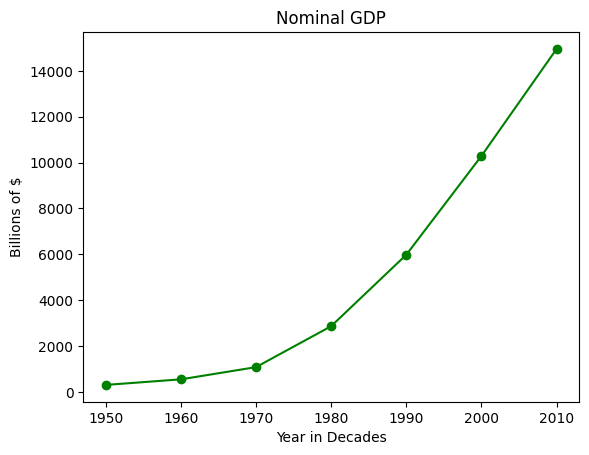

In [42]:
from matplotlib import pyplot as plt 
years = [1950, 1960, 1970, 1980, 1990, 2000, 2010] 
gdp = [300.2, 543.3, 1075.9, 2862.5, 5979.6, 10289.7, 14958.3] 
# create a line chart, years on x-axis, gdp on y-axis 
plt.plot(years, gdp, color='green', marker='o', linestyle='solid') 
# add a title 
plt.title("Nominal GDP") 
# add a label to the y-axis 
plt.ylabel("Billions of $") 
plt.xlabel("Year in Decades") 
plt.show()

## Bar Charts

A bar chart is a good choice when you want to show how some quantity varies among some discrete set of items.


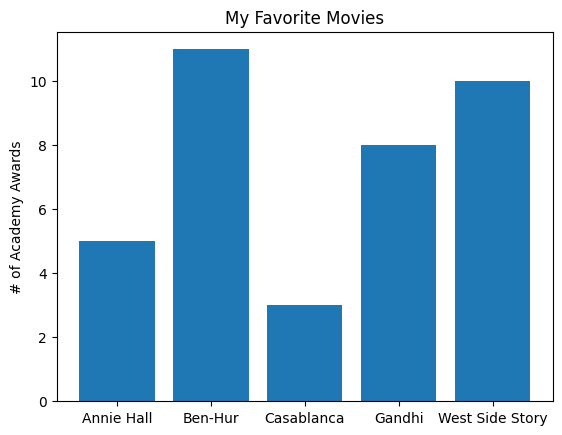

In [43]:
movies = ["Annie Hall", "Ben-Hur", "Casablanca", "Gandhi", "West Side Story"] 
num_oscars = [5, 11, 3, 8, 10] 
# plot bars with left x-coordinates [0, 1, 2, 3, 4], heights [num_oscars] 
plt.bar(range(5), num_oscars) 
plt.title("My Favorite Movies")     
# add a title 
plt.ylabel("# of Academy Awards")   # label the y-axis 
# label x-axis with movie names at bar centers 
plt.xticks(range(len(movies)), movies) 
plt.show()

A bar chart can also be a good choice for plotting histograms of bucketed
 numeric values

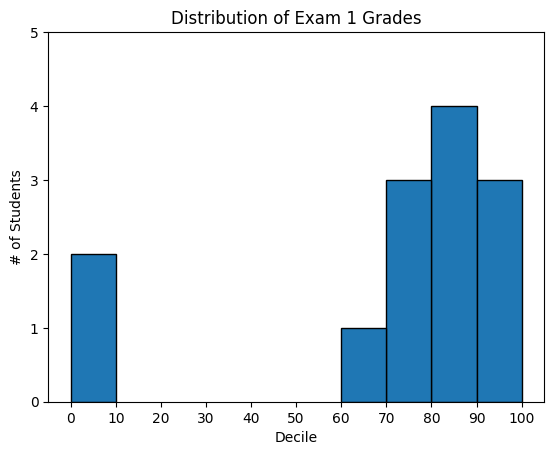

In [44]:
from collections import Counter 
grades = [83, 95, 91, 87, 70, 0, 85, 82, 100, 67, 73, 77, 0] 
 
# Bucket grades by decile, but put 100 in with the 90s 
histogram = Counter(min(grade // 10 * 10, 90) for grade in grades) 
 
plt.bar([x + 5 for x in histogram.keys()],  # Shift bars right by 5 
        histogram.values(),                 # Give each bar its correct height 
        10,                                 # Give each bar a width of 10 
        edgecolor=(0, 0, 0))                # Black edges for each bar 
 
plt.axis([-5, 105, 0, 5])                  # x-axis from -5 to 105, 
                                           # y-axis from 0 to 5 
 
plt.xticks([10 * i for i in range(11)])    # x-axis labels at 0, 10, ..., 100 
plt.xlabel("Decile") 
plt.ylabel("# of Students") 
plt.title("Distribution of Exam 1 Grades") 
plt.show()

 Be judicious when using 
plt.axis
 . When creating bar charts it is
 considered especially bad form for your y-axis not to start at 0, since this is
 an easy way to mislead people (Figure 3-4):


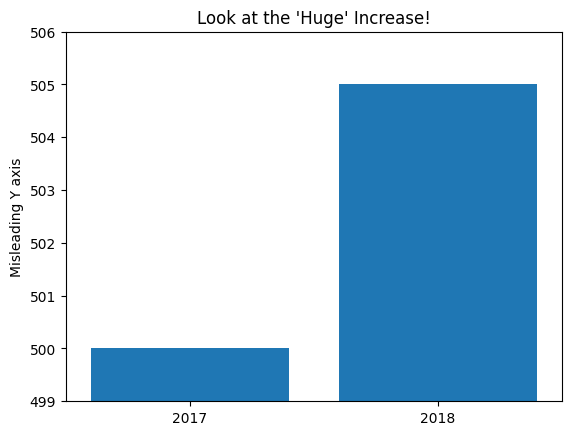

In [45]:
mentions=[500, 505]
years=[2017,2018]

plt.bar(years, mentions, 0.8)
plt.xticks(years)
plt.ylabel("Misleading Y axis")

# if you don't do this matplotlib will lable the x-axis 0, 1 
# and then add a +2.013e3 off in the corner (bad matplotlib!) 
plt.ticklabel_format(useOffset=False) 

plt.axis([2016.5, 2018.5, 499, 506]) 
plt.title("Look at the 'Huge' Increase!") 
plt.show()

Instead we should be using some more sensible axes:

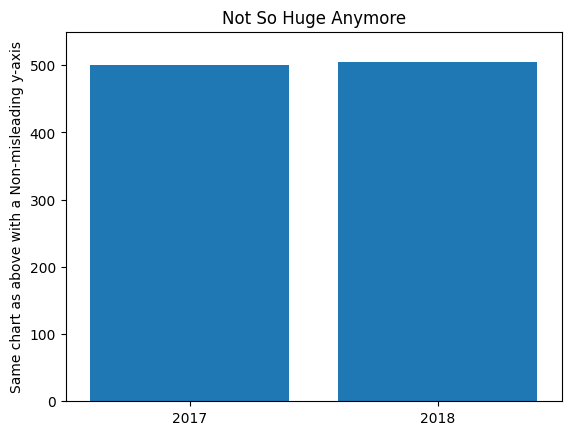

In [46]:
mentions=[500, 505]
years=[2017,2018]

plt.bar(years, mentions, 0.8)
plt.xticks(years)
plt.ylabel("Same chart as above with a Non-misleading y-axis")

# if you don't do this matplotlib will lable the x-axis 0, 1 
# and then add a +2.013e3 off in the corner (bad matplotlib!) 
plt.ticklabel_format(useOffset=False) 

plt.axis([2016.5, 2018.5, 0, 550]) 
plt.title("Not So Huge Anymore") 
plt.show()

## Line Charts

We can make line charts using plt.plot. These are a good choice for showing trends: 

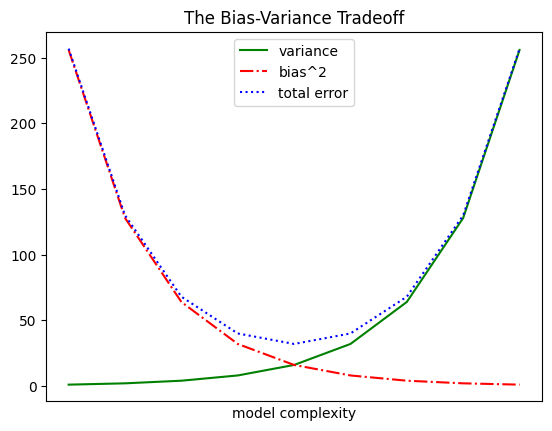

In [47]:
variance = [1, 2, 4, 8, 16, 32, 64, 128, 256] 
bias_squared = [256, 128, 64, 32, 16, 8, 4, 2, 1] 
total_error  = [x + y 
for x, y in zip(variance, bias_squared)] 
xs = [i 
for i, _ in enumerate(variance)] 
# We can make multiple calls to plt.plot 
# to show multiple series on the same chart 
plt.plot(xs, variance,     
'g-',  label='variance')    
plt.plot(xs, bias_squared, 'r-.', label='bias^2')      
# green solid line 
# red dot-dashed line 
plt.plot(xs, total_error,  'b:',  label='total error') # blue dotted line 
# Because we've assigned labels to each series, 
# we can get a legend for free (loc=9 means "top center") 
plt.legend(loc=9) 
plt.xlabel("model complexity") 
plt.xticks([]) 
plt.title("The Bias-Variance Tradeoff") 
plt.show()

## Scatterplots

A scatterplot is the right choice for visualizing the relationship between two paried sets of data:

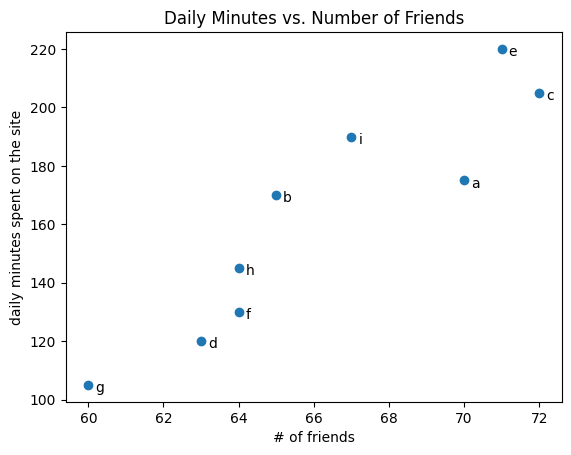

In [48]:
friends = [ 70,  65,  72,  63,  71,  64,  60,  64,  67] 
minutes = [175, 170, 205, 120, 220, 130, 105, 145, 190] 
labels =  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'] 
plt.scatter(friends, minutes) 
# label each point 
for label, friend_count, minute_count in zip(labels, friends, minutes): 
    plt.annotate(label, 
        xy=(friend_count, minute_count), # Put the label with its point 
        xytext=(5, -5),    # but slightly offset               
        textcoords='offset points') 

plt.title("Daily Minutes vs. Number of Friends") 
plt.xlabel("# of friends") 
plt.ylabel("daily minutes spent on the site") 
plt.show()

# Chapter 4: Linear Algebra

## Linear Algebra

### Vectors

In [49]:
import math
from typing import List,Tuple,Callable

In [50]:
Vector = List[float]

height_weight_age=[70, #inches
                   170, #pounds
                    40] #years

grades = [95,   # exam1 
          80,   # exam2 
          75,   # exam3 
          62 ]  # exam4

In [51]:
def add(v:Vector, w:Vector)-> Vector:
    """Adds corresponding elements"""
    assert len(v)== len(w), "vectors must be of same length"

    return [v_i + w_i for v_i, w_i in zip(v,w)] #now I can see through it
                                                # I can feel it
assert add([1, 2, 3], [4, 5, 6]) == [5, 7, 9], "addition results are not equal" 
    
def substract(v:Vector, w:Vector)-> Vector:
    """Adds corresponding elements"""
    assert len(v)== len(w), "vectors must be of same length"
    return [v_i-w_i for v_i,w_i in zip(v,w)] 

assert substract([1, 2, 3], [4, 5, 6]) == [-3, -3, -3] , "subtraction results are not equal"

### Summing up a list of vectors

In [52]:
def vector_sum(vectors: List[Vector]) -> Vector: 
    """Sums all corresponding elements""" 
    # Check that vectors is not empty 
    assert vectors, "no vectors provided!" 
 
    # Check the vectors are all the same size 
    num_elements = len(vectors[0]) 
    assert all(len(v) == num_elements for v in vectors), "different sizes!" 
 
    # the i-th element of the result is the sum of every vector[i] 
    return [sum(vector[i] for vector in vectors) 
            for i in range(num_elements)]

assert vector_sum([[1, 2], [3, 4], [5, 6], [7, 8]]) == [16, 20]
print(vector_sum([[1, 2], [3, 4], [5, 6], [7, 8]]))

[16, 20]


### Scalar Multiplication

In [53]:
def scalar_multiply(c: float, v:Vector)-> Vector:
    """Multiplies every element by c"""
    return [c* v_i for v_i in v]
assert scalar_multiply(2, [1, 2, 3])==[2,4,6], "Scalar Multiplication Output Not same"

### Vector Mean

In [54]:
def vector_mean(vectors: List[Vector])-> Vector:
    """ Computes the element-wise average """
    n=len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

assert vector_mean([[1, 2], [3, 4], [5, 6]]) == [3, 4] , "Vector Mean Not the Same"
# in the example above 
# n=3
# scalar_multiply(1/3,vector_sum([[1, 2], [3, 4], [5, 6]])) 
# vector_sum will return [9, 12] 
# now after the vector_sum's computation is done scalar_multiply will do its job
# scalar_multiply(1/3,[9,12]) 
# Mathematically, (1/3) is approximately 0.333333333333333. 
# However, when we multiply this by each element of the summed vector, 
# we still get the correct average.

### Dot product

In [55]:
def dot(v: Vector, w:Vector)-> float:
    """Computes v_1 * w_1 + ... + v_n * w_n""" 
    assert len(v)==len(w), "vectors must be of same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

assert dot([1, 2, 3], [4, 5, 6]) == 32  # 1 * 4 + 2 * 5 + 3 * 6

In [56]:
def sum_of_squares(v:Vector)->float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v,v)
assert sum_of_squares([1,2,3])==14, "Sum of squares equality error"

In [57]:
def magnitude(v:Vector)->float:
    """ Returns the magnitude (or length) of v """
    # return math.sqrt(sum_of_squares(v))  is as same as
    # this
    return (sum_of_squares(v))**(1/2)

assert magnitude([3,4])==5

### Distance Between two Vectors

In [58]:
def squared_distance(v:Vector, w:Vector)->float:
    return sum_of_squares(substract(v,w))

def distance(v:Vector, w:Vector)->float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v,w)) 
    # or
    return magnitude(substract(v,w))

### Matrices

In [59]:
# Another type alias 
Matrix = List[List[float]] 
A = [[1, 2, 3],  # A has 2 rows and 3 columns 
     [4, 5, 6]]

B = [[1, 2],
     [3, 4],
     [5, 6]] # B has 3 rows and 2 columns 

In [60]:
def shape(A: Matrix)->Tuple[int, int]:
    num_rows=len(A)
    num_cols=len(A[0]) if A else 0
    return num_rows, num_cols

assert shape([[1, 2, 3], [4, 5, 6]]) == (2, 3)  # 2 rows, 3 columns

In [61]:
def get_row(A: Matrix, i: int) -> Vector: 
    """Returns the i-th row of A (as a Vector)""" 
    return A[i]             # A[i] is already the ith row 
 
def get_column(A: Matrix, j: int) -> Vector: 
    """Returns the j-th column of A (as a Vector)""" 
    return [A_i[j]          # jth element of row A_i 
            for A_i in A]   # for each row A_i

In [62]:
def make_matrix(num_rows: int, 
                num_cols: int, 
                entry_fn: Callable[[int, int], float]) -> Matrix: 
    """ 
    Returns a num_rows x num_cols matrix 
    whose (i,j)-th entry is entry_fn(i, j) 
    """ 
    return [[entry_fn(i, j)             # given i, create a list 
             for j in range(num_cols)]  #   [entry_fn(i, 0), ... ] 
            for i in range(num_rows)]   # create one list for each i

In [63]:
def identity_matrix(n:int)-> Matrix:
    """Returns the n x n identity matrix"""
    return make_matrix(n,n, lambda i, j:1 if i==j else 0)

assert identity_matrix(5)==[[1, 0, 0, 0, 0], 
                            [0, 1, 0, 0, 0], 
                            [0, 0, 1, 0, 0], 
                            [0, 0, 0, 1, 0], 
                            [0, 0, 0, 0, 1]]

print(identity_matrix(6))

[[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]]


# Chapter 5: Statistics

**Statistics referes to the mathematics and techniques with which we understand data.**

In [64]:
from typing import List
import math

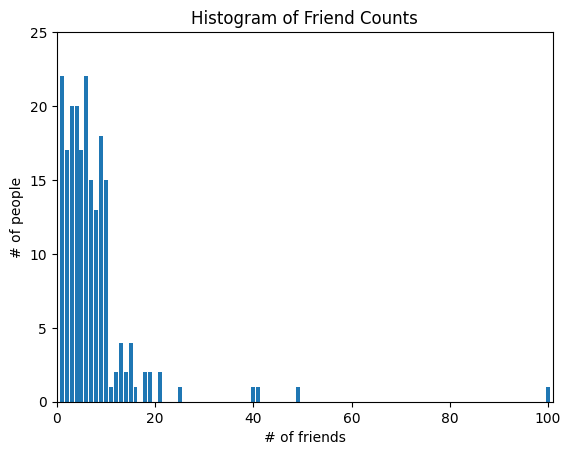

In [65]:
from collections import Counter 
import matplotlib.pyplot as plt 
num_friends = [100.0,49,41,40,25,21,21,19,19,18,18,16,15,15,15,15,
               14,14,13,13,13,13,12,12,11,10,10,10,10,10,10,10,10,
               10,10,10,10,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,
               9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,7,7,7,7,7,7,7,7,7,7,
               7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,
               6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,
               4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
               3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,
               1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
friend_counts = Counter(num_friends) 
xs = range(101)                         
ys = [friend_counts[x] 
# largest value is 100 
for x in xs]     # height is just # of friends 
plt.bar(xs, ys) 
plt.axis([0, 101, 0, 25]) 
plt.title("Histogram of Friend Counts") 
plt.xlabel("# of friends") 
plt.ylabel("# of people") 
plt.show()

In [66]:
nums_point=len(num_friends) 
# You're probably interested in largest and smallest value as well
largest_value=max(num_friends)
print(largest_value)
smallest_num=min(num_friends)
print(smallest_num)

100.0
1


In [67]:
# Which are just special cases of wanting to know the values
# in specific positions:
sorted_values=sorted(num_friends)
smallest_value=sorted_values[0]
second_smallest_value=sorted_values[1]
largest_value=sorted_values[-1]
print(largest_value)
print(smallest_value)

100.0
1


In [68]:
def mean(xs: List[float])->float:
    return sum(xs)/len(xs)
print(mean(num_friends))

7.333333333333333


### Median

In [69]:
# The underscore indicates that these are private functions,as they're 
# intended to be called by our median function not by other people
# using our statistics library

def _median_odd(xs: List[float])->float:
    """If len(xs) is odd, the median is the middle element"""
    return sorted(xs)[len(xs)//2]

def _median_even(xs:List[float])-> float:
    """If len(xs) is even, its the average of the middle 2 elements"""
    sorted_xs=sorted(xs)
    hi_midpoint=len(xs)//2
    return (sorted_xs[hi_midpoint-1] + sorted_xs[hi_midpoint])/2

def median(v:List[float])-> float:
    """Finds the 'middle-most' value of v"""
    return _median_even(v) if len(v) %2 ==0 else _median_odd(v)

assert median([1, 10, 2, 9, 5]) == 5 ,"Values are not the same"
assert median([1, 9, 2, 10]) == (2 + 9) / 2 ,"Values are not the same"

print(median(num_friends))

6.0


### Quantile

A generalization of the median is the quantile, which represents the value under which a certain percentile of the data lies, the median represents the value under which 50% of the data lies.

In [70]:
def quantile(xs: List[float], p: float) -> float:
    """Returns the pth-percentile value in x"""
    p_index = int(p * len(xs))
    return sorted(xs)[p_index]
assert quantile(num_friends, 0.10) == 1
assert quantile(num_friends, 0.25) == 3
assert quantile(num_friends, 0.75) == 9
assert quantile(num_friends, 0.90) == 13

Less commonly you might want to look at the mode, or most common value(s):

In [71]:
def mode(x: List[float]) -> List[float]:
    """Returns a list, since there might be more than one mode"""
    counts = Counter(x)
    max_count = max(counts.values())
    return [x_i for x_i, count in counts.items()
    if count == max_count]
assert set(mode(num_friends)) == {1, 6}

### Dispersion

Dispersion is a way of measuring how spread out the data is. These measures tell us how much the values in a dataset differ from each other. If the measure is close to zero, it means the data points are very close together, and if the value is large, it means the data points are more spread out. One simple way to measure this is by calculating the range, which is just the difference between the largest and smallest values in the data.

In [72]:
def data_range(xs: List[float]) -> float:
    return max(xs) - min(xs)
assert data_range(num_friends) == 99

The range is zero precisely when the max and min are equal, which can only
happen if the elements of x are all the same, which means the data is as
undispersed as possible. Conversely, if the range is large, then the max is
much larger than the min and the data is more spread out.

Like the median, the range doesn’t really depend on the whole dataset. A
dataset whose points are all either 0 or 100 has the same range as a dataset
whose values are 0, 100, and lots of 50s. But it seems like the first dataset
“should” be more spread out.

A more complex measure of dispersion is the variance, which is computed as: 

In [73]:
Vector = List[float]
def sum_of_squares(v:Vector)->float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v,v)

def dot(v: Vector, w:Vector)-> float:
    """Computes v_1 * w_1 + ... + v_n * w_n""" 
    assert len(v)==len(w), "vectors must be same lenght"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

In [74]:
assert dot([1, 2, 3], [4, 5, 6]) == 32  # 1 * 4 + 2 * 5 + 3 * 6

# why do you think this function is called de_mean?
def de_mean(xs: List[float])-> List[float]:
    """ Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar=mean(xs)
    return [x-x_bar for x in xs]

def variance(xs: List[float])->float:
    """ Almost the average squared deviation from the mean"""
    assert len(xs)>=2,  "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    return sum_of_squares(deviations) / (n - 1)

# assert 81.54 < variance(num_friends) < 81.55
print(variance(num_friends))

81.54351395730716


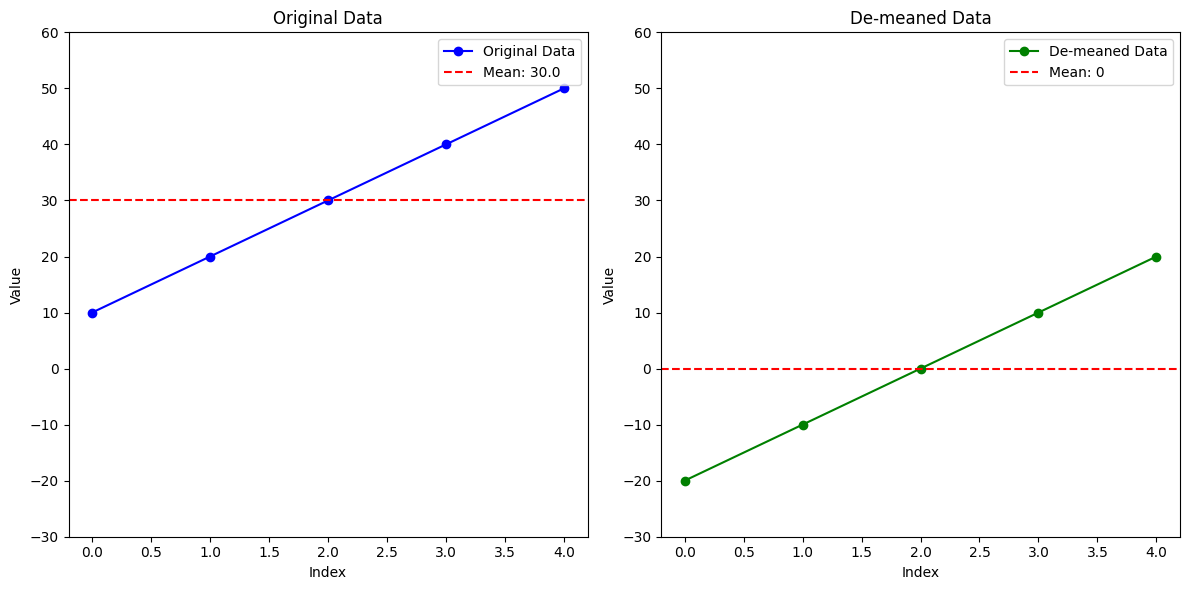

In [75]:
import matplotlib.pyplot as plt

# Example data
xs = [10, 20, 30, 40, 50]

# Calculate the mean
x_bar = sum(xs) / len(xs)

# De-mean the data
demeaned_xs = [x - x_bar for x in xs]

# Set the y-axis limits for both plots
y_limits = (min(demeaned_xs) - 10, max(xs) + 10)

# Plotting the data
plt.figure(figsize=(12, 6))

# Original data
plt.subplot(1, 2, 1)
plt.plot(xs, 'bo-', label='Original Data')
plt.axhline(y=x_bar, color='r', linestyle='--', label=f'Mean: {x_bar}')
plt.ylim(y_limits)
plt.title('Original Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# De-meaned data
plt.subplot(1, 2, 2)
plt.plot(demeaned_xs, 'go-', label='De-meaned Data')
plt.axhline(y=0, color='r', linestyle='--', label='Mean: 0')
plt.ylim(y_limits)
plt.title('De-meaned Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


Basically the whole dataset gets *shifted* below its initial position by mean.

Now, whatever units our data is in (e.g., “friends”), all of our measures of
central tendency are in that same unit. The range will similarly be in that
same unit. The variance, on the other hand, has units that are the square of
the original units (e.g., “friends squared”). As it can be hard to make sense
of these, we often look instead at the standard deviation:

In [76]:
def standard_deviation(xs: List[float])->float:
    """The standard deviation is the square root of variance"""
    return math.sqrt(variance(xs))

assert 9.02 < standard_deviation(num_friends) < 9.04

**But what's the significance of Standard Deviation?**

A large standard deviation indicates that the data points are spread out over a wider range, which means there’s high variability from the mean. Conversely, a small standard deviation means that the data points tend to be closer to the mean, indicating less variability.

A standard deviation helps to understand the distribution of data. For instance, in a normal distribution:

- About 68% of the data lies within one standard deviation of the mean.
- About 95% of the data lies within two standard deviations of the mean.
- About 99.7% of the data lies within three standard deviations of the mean.

Both the range and the standard deviation have the same outlier problem that we saw earlier for the mean. Using the same example, if our friendliest
user had instead 200 friends, the standard deviation would be 14.89—more
than 60% higher!

If you think about the outlier problem we're talking about, it is obvious that SD(standard deviation) is prone to that problem because the SD itself is calculated using the mean(which is prone to the outlier problem).

A more robust alternative computes the difference between the 75th percentile value and the 25th percentile value, which is quite plainly unaffected by a small number of outliers:

In [77]:
def interquartile_range(xs: Vector)->float:
    """ Returns the difference between teh 75%-ile and the 25%-ile"""
    return quantile(xs, 0.75) - quantile(xs, 0.25)

assert interquartile_range(num_friends)==6

## Correlation

### Covariance

Variance is a measure of how much one variable spreads out from its mean (average). In simpler terms, it tells you how "spread out" or "scattered" the data points are for a single set of numbers.

Example:
Imagine you have the heights of five people: 150 cm, 155 cm, 160 cm, 165 cm, and 170 cm. The mean (average) height is 160 cm.

- If the heights are very close to 160 cm, the variance will be small.
- If the heights are all over the place, like 130 cm, 160 cm, 190 cm, etc., the variance will be large.

Covariance is similar, but instead of looking at how one variable spreads from its mean, it looks at how **two variables** change together. In other words, it tells us whether two things tend to increase together or if one increases while the other decreases. Basically its tell us about how one variable is related to other.

Example:
Imagine you are comparing the amount of time people spend on a website (daily minutes) and the number of friends they have on the site. If people who spend more time also tend to have more friends, then the covariance will be positive(both increase together). If people who spend more time have fewer friends, the covariance will be negative(one increases and the other decreases).
- Positive covariance: If one variable increases and the other also increases (e.g., height and weight).
- Negative covariance: If one variable increases and the other decreases (e.g., exercise frequency and weight).

**Simple Comparison:**

- **Variance**: Measures the spread of one variable (e.g., "How much do people’s daily minutes vary from the average?").
- **Covariance**: Measures how two variables move together (e.g., "Do people who spend more time on the site also have more friends?").

In [78]:
daily_minutes = [1,68.77,51.25,52.08,38.36,44.54,57.13,51.4,41.42,31.22,
                 34.76,54.01,38.79,47.59,49.1,27.66,41.03,36.73,48.65,
                 28.12,46.62,35.57,32.98,35,26.07,23.77,39.73,40.57,31.65,
                 31.21,36.32,20.45,21.93,26.02,27.34,23.49,46.94,30.5,
                 33.8,24.23,21.4,27.94,32.24,40.57,25.07,19.42,22.39,18.42,
                 46.96,23.72,26.41,26.97,36.76,40.32,35.02,29.47,30.2,31,
                 38.11,38.18,36.31,21.03,30.86,36.07,28.66,29.08,37.28,
                 15.28,24.17,22.31,30.17,25.53,19.85,35.37,44.6,17.23,
                 13.47,26.33,35.02,32.09,24.81,19.33,28.77,24.26,31.98,
                 25.73,24.86,16.28,34.51,15.23,39.72,40.8,26.06,35.76,
                 34.76,16.13,44.04,18.03,19.65,32.62,35.59,39.43,14.18,
                 35.24,40.13,41.82,35.45,36.07,43.67,24.61,20.9,21.9,
                 18.79,27.61,27.21,26.61,29.77,20.59,27.53,13.82,33.2,
                 25,33.1,36.65,18.63,14.87,22.2,36.81,25.53,24.62,26.25,
                 18.21,28.08,19.42,29.79,32.8,35.99,28.32,27.79,35.88,
                 29.06,36.28,14.1,36.63,37.49,26.9,18.58,38.48,24.48,
                 18.95,33.55,14.24,29.04,32.51,25.63,22.22,19,32.73,15.16,
                 13.9,27.2,32.01,29.27,33,13.74,20.42,27.32,18.23,35.35,
                 28.48,9.08,24.62,20.12,35.26,19.92,31.02,16.49,12.16,30.7,
                 31.22,34.65,13.13,27.51,33.2,31.57,14.1,33.42,17.44,
                 10.12,24.42,9.82,23.39,30.93,15.03,21.67,31.09,33.29,
                 22.61,26.89,23.48,8.38,27.81,32.35,23.84]
daily_hours = [dm / 60 for dm in daily_minutes]

def covariance(xs: Vector, ys:Vector)->float:
    assert len(xs) == len(ys), " xs and ys must have same number of elements "
    return dot(de_mean(xs), de_mean(ys)) / (len(xs)-1)

assert 22.42 < covariance(num_friends, daily_minutes) < 22.43
assert 22.42 / 60 < covariance(num_friends, daily_hours) < 22.43 / 60

Now again, what does covariance tell us?

- A positive covariance means that when one variable goes up, the other tends to go up too (or when one goes down, the other tends to go down).
- A negative covariance means that when one variable goes up, the other tends to go down (and vice versa).
- A covariance close to zero means there's no clear relationship between how the two variables change.

Nonetheless, this number can be hard to interpret, for a couple of reasons:

- Its units are the product of the inputs' units  (e.g., friend-minutesper-day), which can be hard to make sense of. (What’s a “friend-minute-per-day”?)

- If each user had twice as many friends (but the same number of minutes), the covariance would be twice as large. But in a sense, the variables would be just as interrelated. Said differently, it’s hard to say what counts as a “large” covariance.

For this reason, it’s more common to look at the correlation, which divides
out the standard deviations of both variables:

In [79]:
def correlation(xs: List[float], ys: List[float]) -> float:
    """Measures how much xs and ys vary in tandem about their means"""
    stdev_x = standard_deviation(xs)
    stdev_y = standard_deviation(ys)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(xs, ys) / stdev_x / stdev_y
    else:
        return 0 # if no variation, correlation is zero
assert 0.24 < correlation(num_friends, daily_minutes) < 0.25
assert 0.24 < correlation(num_friends, daily_hours) < 0.25

The correlation is unitless and always lies between –1 (perfect
anticorrelation) and 1 (perfect correlation). A number like 0.25 represents a
relatively weak positive correlation.

In [80]:
daily_minutes = [1,68.77,51.25,52.08,38.36,44.54,57.13,51.4,41.42,31.22,
                 34.76,54.01,38.79,47.59,49.1,27.66,41.03,36.73,48.65,
                 28.12,46.62,35.57,32.98,35,26.07,23.77,39.73,40.57,31.65,
                 31.21,36.32,20.45,21.93,26.02,27.34,23.49,46.94,30.5,
                 33.8,24.23,21.4,27.94,32.24,40.57,25.07,19.42,22.39,18.42,
                 46.96,23.72,26.41,26.97,36.76,40.32,35.02,29.47,30.2,31,
                 38.11,38.18,36.31,21.03,30.86,36.07,28.66,29.08,37.28,
                 15.28,24.17,22.31,30.17,25.53,19.85,35.37,44.6,17.23,
                 13.47,26.33,35.02,32.09,24.81,19.33,28.77,24.26,31.98,
                 25.73,24.86,16.28,34.51,15.23,39.72,40.8,26.06,35.76,
                 34.76,16.13,44.04,18.03,19.65,32.62,35.59,39.43,14.18,
                 35.24,40.13,41.82,35.45,36.07,43.67,24.61,20.9,21.9,
                 18.79,27.61,27.21,26.61,29.77,20.59,27.53,13.82,33.2,
                 25,33.1,36.65,18.63,14.87,22.2,36.81,25.53,24.62,26.25,
                 18.21,28.08,19.42,29.79,32.8,35.99,28.32,27.79,35.88,
                 29.06,36.28,14.1,36.63,37.49,26.9,18.58,38.48,24.48,
                 18.95,33.55,14.24,29.04,32.51,25.63,22.22,19,32.73,15.16,
                 13.9,27.2,32.01,29.27,33,13.74,20.42,27.32,18.23,35.35,
                 28.48,9.08,24.62,20.12,35.26,19.92,31.02,16.49,12.16,30.7,
                 31.22,34.65,13.13,27.51,33.2,31.57,14.1,33.42,17.44,
                 10.12,24.42,9.82,23.39,30.93,15.03,21.67,31.09,33.29,
                 22.61,26.89,23.48,8.38,27.81,32.35,23.84]

num_friends = [100.0,49,41,40,25,21,21,19,19,18,18,16,15,15,15,15,
               14,14,13,13,13,13,12,12,11,10,10,10,10,10,10,10,10,
               10,10,10,10,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,
               9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,7,7,7,7,7,7,7,7,7,7,
               7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,
               6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,
               4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
               3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,
               1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]


# give me the code to draw a 

# Chapter - 6: Probability

Edward Gibbon, an English historian and author, best known for his work "The History of the Decline and Fall of the Roman Empire." Gibbon used this phrase to highlight the paradox of probability: *while probability laws are generally reliable and useful, they can sometimes lead to misleading conclusions when applied to specific cases.* It's a reminder that while statistical methods are powerful tools, they must be applied with caution and an understanding of their limitations.

Gibbon's statement points out the quirks and pitfalls of applying probability to specific situations. Here are a few examples to illustrate why he might have said that:

Gambler’s Fallacy: A person who believes that after a series of losses, they’re due for a win, is falling prey to the gambler’s fallacy. This is because each event is independent in games of chance like roulette or slot machines. Probability in general works out, but in particular, it doesn’t guarantee any specific outcome. Consider flipping a fair coin. The chances of landing heads or tails are always 50%. If the coin lands on heads five times in a row, a person might think tails is "due" next. However, the probability remains 50% for each flip, independent of previous outcomes.

Insurance: Insurance companies rely on probabilities to assess risk and set premiums. In general, this works well across large populations. However, an individual might never face any of the risks they’re insured against, making their personal experience diverge from the probabilistic expectation.

Medical Tests: Probabilities are used to determine the likelihood of a disease given a positive test result. However, a specific patient might still receive a false positive or false negative, leading to outcomes that can seem at odds with general probability laws.

Weather Forecasting: Weather predictions are based on probabilities. Generally, they provide a good estimate. But on a particular day, you might experience rain despite a forecast of clear skies, or vice versa.

In essence, while probability is a powerful tool for making general predictions, it can sometimes lead to unexpected results in specific cases, highlighting the importance of context and careful application.

### Dependence And Independence

Roughly speaking, we say that two events E and F are dependent if knowing something about whether E happens gives us information about whether F happens(and vice versa). Otherwise, they(the events E and F) are indepenent.

For example if we flip a fair coin twice, knowing whether the first flip is heads gives us no information about whether the second flip is heads. These events are independent. On the other hand, knowing whether the first flip is heads - Event E certainly gives us information about whether both flips are tails - Event F. If the first flip is heads, then definitely it's not the case that both flips are tails. These two events are dependent.  

Mathematically, we say that two events E and F are independent if the probability that they both happen is the product of the probabilities that each one happens:

<p style="text-align:center;">P(E, F) = P(E)P(F)</p>

In the example, the probability of "First flip heads" is 1/2, and the probability of "both flips tails" is 1/4, but the probability of "first flip heads and both flips tails" is 0. Here's a detailed exaplaination:

The statement is explaining a scenario where two events, **E** and **F**, are involved in a probability calculation:

1. **Define the Events:**
   - Event **E**: The outcome of the *first coin flip* is **heads**.
   - Event **F**: The outcome of *both flips* is **tails**.

2. **Individual Probabilities:**
   - **P(E)** (probability of the first flip being heads): Since a fair coin has two possible outcomes (heads or tails), the probability of heads on the first flip is \( \frac{1}{2} \).
   - **P(F)** (probability of both flips being tails): For two coin flips to both land on tails, each flip needs to be tails, with a probability of \( \frac{1}{2} \times \frac{1}{2} = \frac{1}{4} \).

3. **Intersection of Events (E and F):**
   - The intersection of **E** and **F** is the probability that both events occur simultaneously: the *first flip* results in heads (**E**) *and* *both flips* result in tails (**F**).
   - However, if the first flip is heads (event **E**), then it’s impossible for both flips to be tails (event **F**), as this would require the first flip to be tails.
   - Therefore, the probability of both events **E** and **F** happening at the same time, \( P(E \text{ and } F) \), is **0**.

4. **Understanding the Multiplication Rule:**
   - If **E** and **F** were independent events, then P(E and F) = P(E) X P(F). However, in this case, **E** and **F** are *not independent* because the outcome of the first flip affects the possibility of having both flips as tails.
   - Since **E** and **F** cannot occur together, their intersection probability is zero, which violates the rule for independent events: \( P(E, F) \neq P(E) \times P(F) \).
<span style="color:red">
E and F cannot occur together - wtf does that mean?
</span>

### Multiplication Rule
The **multiplication rule** in probability helps calculate the probability of two events happening together, or in other words, the probability of the intersection of two events.

There are two forms of the multiplication rule: 

1. **For Independent Events**
2. **For Dependent Events**

### 1. Multiplication Rule for Independent Events

If two events, **A** and **B**, are **independent**, it means that the occurrence of one event does not affect the probability of the other event. In such cases, the multiplication rule states:

\[
P(A \text{ and } B) = P(A) \times P(B)
\]

This rule works when the events are independent. Here’s an example:

- **Example**: Let’s say you roll a die and flip a coin. The events “rolling a 3” and “flipping heads” are independent. The probability of rolling a 3 is \( \frac{1}{6} \), and the probability of flipping heads is \( \frac{1}{2} \). According to the multiplication rule for independent events:
  
  \[
  P(\text{rolling a 3 and flipping heads}) = P(\text{rolling a 3}) \times P(\text{flipping heads}) = \frac{1}{6} \times \frac{1}{2} = \frac{1}{12}
  \]

### 2. Multiplication Rule for Dependent Events

When events are **dependent**, the occurrence of one affects the probability of the other. In this case, we use a modified form of the multiplication rule:

\[
P(A \text{ and } B) = P(A) \times P(B \mid A)
\]

Here, \( P(B \mid A) \) represents the **conditional probability** of **B** given that **A** has already occurred.

- **Example**: Suppose we have a deck of 52 cards and we draw two cards in sequence *without replacement* (i.e., we don’t put the first card back before drawing the second). Let **A** be the event “first card drawn is an Ace” and **B** be the event “second card drawn is an Ace.”

  - \( P(A) = \frac{4}{52} \) (since there are 4 Aces in a 52-card deck).
  - \( P(B \mid A) = \frac{3}{51} \) (if the first card was an Ace, only 3 Aces remain in a 51-card deck).

  So, by the multiplication rule for dependent events:

  \[
  P(\text{both cards are Aces}) = P(A) \times P(B \mid A) = \frac{4}{52} \times \frac{3}{51} = \frac{12}{2652} \approx 0.0045
  \]

### Summary

- **Independent Events**: \( P(A \text{ and } B) = P(A) \times P(B) \)
- **Dependent Events**: \( P(A \text{ and } B) = P(A) \times P(B \mid A) \)

The multiplication rule is a powerful tool because it lets us calculate the likelihood of multiple events happening together by understanding how they relate to each other—whether they are independent or dependent.

# Chapter 7: Hypothesis And Inference

Often as data scientists, we'll want to test whether a certain hypothesis is likely to be true. For our purpose, hypotheses are assertions like "this coin is fair" or "data scientists prefer Python to R" or "people are more likely to navigate away from the page without even reading the content if we pop up an irritating interstitial advertisement with a tiny, hard-to-find close button" that can be translated into statistics about data. Under various assumptions,
those statistics can be thought of as observations of random variables from
known distributions, which allows us to make statements about how likely
those assumptions are to hold.

## Flipping A Coin

Imagine we have a coin and we want to test whether its fair. We'll make the assumption that the coin has some probablity p of landing heads, and so our null hypothesis is that the coin is fair - that is, that p=0.5. We'll test this against the alternative hypothesis p != 0.5.

In particular, our test will involve flipping the coin some number, n, times
and counting the number of heads, X. Each coin flip is a Bernoulli trial,
which means that X is a Binomial(n,p) random variable.

In [81]:
from typing import Tuple
import math
def normal_approximation_to_binomial(n: int, p: float) -> Tuple[float, float]:
    """Returns mu and sigma corresponding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

# Chapter 8: Gradient Descent

> Those who boast of their descent, brag on what they owe to others. - Seneca

This quote means that when people brag about their heritage or ancestry, they're essentially boasting about achievements or qualities that they didn't earn themselves but were handed down by others. In other words, they're taking credit for something that isn't their own accomplishment. It’s a reminder that true merit lies in personal achievements rather than inherited status. **Ever thought about what qualities you value in others?**

# Chapter 9: Getting Data